In [12]:
import sys 
sys.path.insert(0, '../')

In [13]:

from common.common import create_folder
from common.pytorch import load_model
from common.conf_loader import ConfLoader
import configs.config_classes as conf_objs
import pytorch_pretrained_bert as Bert
from model.utils import age_vocab
from common.common import load_obj
from dataLoader.MLM import MLMLoader
from torch.utils.data import DataLoader
import pandas as pd
from model.MLM import BertForMaskedLM
from model.optimiser import adam
import sklearn.metrics as skm
import numpy as np
import torch
import time
import torch.nn as nn
import os

conf_loader = ConfLoader('../configs/proact')



In [14]:

file_config = conf_loader.load_configs('file_config_mlm.json')
global_params = conf_loader.load_configs( 'global_params.json')
optim_param = conf_loader.load_configs('optimizer_params.json')


In [15]:

BertVocab = load_obj(file_config['vocab'])
ageVocab, _ = age_vocab(max_age=global_params['max_age'], mon=global_params['month'], symbol=global_params['age_symbol'])



In [16]:
data = pd.concat([pd.read_parquet(f'../data/for_behrt_wrt_months_less_than_3_months.parquet'),
                 pd.read_parquet(f'../data/for_behrt_wrt_months_more_than_3_months_fixed.parquet').iloc[:2536,:]],
                ignore_index=True)



In [17]:
def get_loader(data):
    Dset = MLMLoader(data, BertVocab['token2idx'], ageVocab, max_len=global_params['max_len_seq'], code='FRS_diag', lab_test='CK')
    return DataLoader(dataset=Dset, batch_size=global_params['batch_size'], shuffle=True, num_workers=6)

    

In [18]:
# Dset = MLMLoader(data, BertVocab['token2idx'], ageVocab, max_len=global_params['max_len_seq'], code='FRS_diag')
# train_load = DataLoader(dataset=Dset, batch_size=global_params['batch_size'], shuffle=True, num_workers=6)
train_load = get_loader(data)

In [19]:
model_config = conf_loader.load_model_configs('model_params.json', global_params, BertVocab, ageVocab)


In [20]:

conf = conf_objs.BertConfig(model_config)
model = BertForMaskedLM(conf)

In [21]:
model = model.to(global_params['device'])
optim = adam(params=list(model.named_parameters()), config=optim_param)

t_total value of -1 results in schedule not being applied


In [22]:
def cal_acc(label, pred):
    logs = nn.LogSoftmax(dim=-1)
    label=label.cpu().numpy()
    ind = np.where(label!=-1)[0]
    truepred = pred.detach().cpu().numpy()
    truepred = truepred[ind]
    truelabel = label[ind]
    truepred = logs(torch.tensor(truepred))
    outs = [np.argmax(pred_x) for pred_x in truepred.numpy()]
    precision = skm.precision_score(truelabel, outs, average='micro')
    return precision

In [23]:

def train(e, loader):
    tr_loss = 0
    temp_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt= 0
    start = time.time()

    for step, batch in enumerate(loader):
        cnt +=1
        batch = tuple(t.to(global_params['device']) for t in batch)
        age_ids, input_ids, posi_ids, creatinine ,segment_ids, attMask, masked_label = batch
        loss, pred, label = model(input_ids, age_ids, segment_ids, creatinine, posi_ids,attention_mask=attMask, masked_lm_labels=masked_label)
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        loss.backward()
        
        temp_loss += loss.item()
        tr_loss += loss.item()
        
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        if step % 50==0:
            print("epoch: {}\t| cnt: {}\t|Loss: {}\t| precision: {:.4f}\t| time: {:.2f}".format(e, cnt, temp_loss/50, cal_acc(label, pred), time.time()-start))
            temp_loss = 0
            start = time.time()
            
        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()

    print("** ** * Saving fine - tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    create_folder(file_config['model_path'])
    output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])

    torch.save(model_to_save.state_dict(), output_model_file)
        
    cost = time.time() - start
    return tr_loss, cost

In [24]:
os.path.join(file_config['model_path'], file_config['model_name'])
data_len = len(data)

In [25]:
f = open(os.path.join(file_config['model_path'], file_config['file_name']), "w")
f.write('{}\t{}\t{}\n'.format('epoch', 'loss', 'time'))
for e in range( 1000):
   loss, time_cost = train(e, train_load)
   loss = loss/data_len
   f.write('{}\t{}\t{}\n'.format(e, loss, time_cost))
f.close()

epoch: 0	| cnt: 1	|Loss: 0.08103041648864746	| precision: 0.0198	| time: 7.64
epoch: 0	| cnt: 51	|Loss: 3.617884063720703	| precision: 0.1111	| time: 21.83
epoch: 0	| cnt: 101	|Loss: 3.432071123123169	| precision: 0.1949	| time: 20.72
epoch: 0	| cnt: 151	|Loss: 3.339794535636902	| precision: 0.1942	| time: 20.80
** ** * Saving fine - tuned model ** ** * 
epoch: 1	| cnt: 1	|Loss: 0.06510134220123291	| precision: 0.2353	| time: 6.95
epoch: 1	| cnt: 51	|Loss: 3.28420729637146	| precision: 0.1782	| time: 20.84
epoch: 1	| cnt: 101	|Loss: 3.2051183080673216	| precision: 0.1341	| time: 21.67
epoch: 1	| cnt: 151	|Loss: 3.111806664466858	| precision: 0.2095	| time: 21.01
** ** * Saving fine - tuned model ** ** * 
epoch: 2	| cnt: 1	|Loss: 0.05798407554626465	| precision: 0.3000	| time: 6.94
epoch: 2	| cnt: 51	|Loss: 3.060059471130371	| precision: 0.2222	| time: 21.88
epoch: 2	| cnt: 101	|Loss: 3.0213208198547363	| precision: 0.3153	| time: 21.16
epoch: 2	| cnt: 151	|Loss: 2.9331689977645876	| pr

C:\Users\mannh\Anaconda3\envs\BEHRT_MSC\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


In [15]:
# import os
# output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])
# # with open(output_model_file) as fh:
# model.load_state_dict(torch.load(output_model_file))





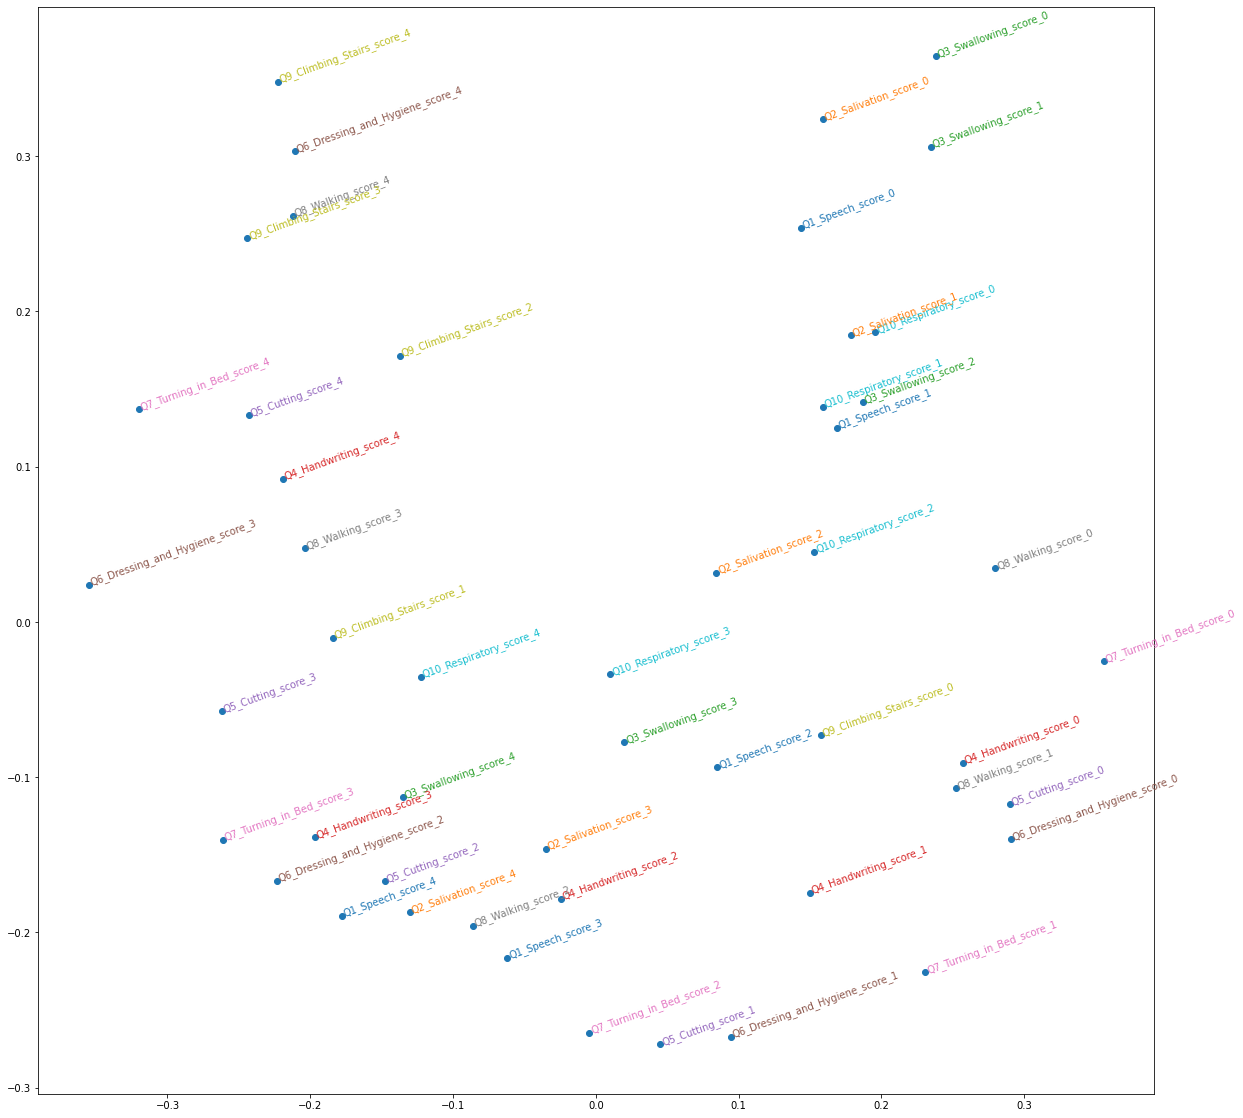

In [17]:
import pandas as pd

with torch.no_grad():
    idx = []
    for key in BertVocab['token2idx'].keys():
        if key.startswith('Q'):
            idx.append(BertVocab['token2idx'][key])
#     idx = sorted(list(BertVocab['token2idx'].values()))
    a = model.bert.embeddings.word_embeddings(torch.LongTensor(idx))
a = a.numpy()
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
aa = pca.fit_transform(a)
colors = ['blue', 'orange', 'green', 'red','purple', 'brown','pink','gray','olive','cyan']
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots()
txt_list = [BertVocab['idx2token'][i] for i in idx]
plt.scatter(aa[:,0], aa[:,1])
for j, txt in enumerate(txt_list):
    color_idx = int(txt[:txt.find('_')].replace('Q',''))-1
    ax.annotate(txt, (aa[j,0], aa[j,1]),color=f'tab:{colors[color_idx]}', rotation=20)
plt.savefig('ALS_3_Visits_MLM.jpg', dpi=400)
#







In [18]:
pca.explained_variance_ratio_

array([0.08626386, 0.07275958], dtype=float32)